In [1]:
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import jaccard_score
from matplotlib.colors import ListedColormap
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
from rdkit.Chem.Scaffolds.MurckoScaffold import MakeScaffoldGeneric

import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs
from scripts import visualization
import importlib as imp
imp.reload(visualization)
import numpy as np
from rdkit.Chem import PandasTools



In [2]:
def KL_divergence_prep(df1, df2, smiles1, smiles2):
    """
    Prepare data and compute similarity metrics between two sets for KL divergence.

    Args:
        df1 (pd.DataFrame): First DataFrame containing data.
        df2 (pd.DataFrame): Second DataFrame containing data.
        smiles1 (str): Column name for SMILES in df1.
        smiles2 (str): Column name for SMILES in df2.

    Returns:
        list: List of highest Tanimoto coefficients between the two sets.
    """
    highest_TC, avg_TC = [], []

    # Generate Morgan fingerprints for compounds in df1 and df2
    fps1 = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 3, nBits=2048) for x in df1[smiles1].tolist()]
    fps2 = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 3, nBits=2048) for x in df2[smiles2].tolist()]

    df1['fps'] = fps1
    df2['fps'] = fps2
    # Calculate Tanimoto coefficients between compounds in df1 and df2
    array_index_recall_set = []
    array_index_output_set = []
    array_for_smiles_recall = []
    array_for_smiles_output = []
    
    arr = pd.DataFrame(columns = ['recall_id', 'output_id','tc','recall_set', 'output_set'])
    print("Delka recall setu: ", len(df1))
    for x in range(len(df1)):
        print("X: ", x)
        fps = df1.loc[x]['fps']
        total_compared, total_tca, tc, tca = 0, 0, 0, 0
        for y in range(len(df2)):
            fps_inp = df2.loc[y]['fps']
            total_compared += 1
            tca = DataStructs.FingerprintSimilarity(fps, fps_inp)
            total_tca += tca
            if tca > tc:
                tc = tca
                if tc == 1:
                    if x not in array_index_recall_set or y not in array_index_output_set:
                        if df1[smiles1][x] not in array_for_smiles_recall or df2[smiles2][y] not in array_for_smiles_output:
                            index_recall = df1[df1[smiles1] == df1[smiles1][x]].index.tolist()
                            index_output = df2[df2[smiles2] == df2[smiles2][y]].index.tolist()
                            for z in index_recall:
                                array_index_recall_set.append(z)
                            for t in index_output:
                                array_index_output_set.append(t)
                            arr.loc[-1] = [index_recall,index_output,tc,df1[smiles1][x], df2[smiles2][y]]
                            arr.index = arr.index + 1
                            arr = arr.sort_index()    
                        

        highest_TC.append(tc)
        avg_TC.append(float(total_tca / total_compared))
        
    PandasTools.AddMoleculeColumnToFrame(arr,smilesCol='recall_set', molCol = 'recall_compound')
    PandasTools.AddMoleculeColumnToFrame(arr,smilesCol='output_set', molCol = 'output_compound')
    display(arr)

    
    #print("Array with index in recall_set with 100% similarity: ", array_for_inex_for_recall_set)
    # Print some statistics
    #print("I>0.7 ", [i for i in highest_TC if i > 0.7])
    print("How much TC = 1: ", str(sum(i == 1 for i in highest_TC)))
    #print(np.asarray(highest_TC).mean())
    #print(highest_TC)

    return highest_TC, arr

In [14]:
def KL_histograms(data1, data2):

    
    # Plot the histograms
    plt.hist(data1, bins=100, range=[0.0, 1.0], alpha=0.5, color='blue', label='Molpher library')
    plt.hist(data2, bins=100, range=[0.0, 1.0], alpha=0.5, color='orange', label='DrugEx library')

    # Calculate and plot vertical lines for the average values
    plt.axvline(np.asarray(data1).mean(), color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(np.asarray(data2).mean(), color='orange', linestyle='dashed', linewidth=1)

    plt.xlabel('Highest Tc', fontsize = 18)
    plt.ylabel('Frequency' , fontsize = 18)
    plt.title('Recall Set vs. Molpher and DrugEx', fontsize = 20)
    plt.grid(True)
    plt.legend()
    return plt
    #plt.show()

In [101]:
def KL_histograms_more(ax, data1, data2):

    # Plot the histograms
    ax.hist(data1, bins=100, range=[0.0, 1.0], alpha=0.5, color='blue', label='Molpher library dis 0')
    ax.hist(data2, bins=100, range=[0.0, 1.0], alpha=0.5, color='orange', label='DrugEx library dis 0')

    # Calculate and plot vertical lines for the average values
    ax.axvline(np.asarray(data1).mean(), color='blue', linestyle='dashed', linewidth=1)
    ax.axvline(np.asarray(data2).mean(), color='orange', linestyle='dashed', linewidth=1)

    ax.set_xlabel('Highest Tc', fontsize = 18)
    ax.set_ylabel('Frequency' , fontsize = 18)

    ax.grid(True)
    ax.legend()


In [3]:
def KL_histograms_for_all_10(rows, data, text):

    fig, ax = plt.subplots(nrows=rows, ncols=2, figsize=(20, 22), sharex=True)  

    number = 0
    number_sim = 0
    for row in range(rows):
    # Plot the histograms
        for column in range(2):
            if number < 5:
                print(number)
                data1 = f"generator_1_dis_{number}"
                data2 = f"generator_2_dis_{number}"

                ax[row,column].hist(data[data1], bins=100, range=[0.0, 1.0], alpha=0.5, color='blue', label=f'Molpher library dis {number}')
                ax[row,column].hist(data[data2], bins=100, range=[0.0, 1.0], alpha=0.5, color='orange', label=f'DrugEx library dis {number}')
            
                # Calculate and plot vertical lines for the average values
                ax[row,column].axvline(np.asarray(data[data1]).mean(), color='blue', linestyle='dashed', linewidth=1)
                ax[row,column].axvline(np.asarray(data[data2]).mean(), color='orange', linestyle='dashed', linewidth=1)
            
                ax[row,column].set_xlabel('Highest Tc', fontsize = 18)
                ax[row,column].set_ylabel('Frequency' , fontsize = 18)
            
                ax[row,column].grid(True)
                ax[row,column].legend()
                number += 1
            else:
                print(number)
                data1 = f"generator_1_sim_{number_sim}"
                data2 = f"generator_2_sim_{number_sim}"
                number_sim += 1
           
                ax[row,column].hist(data[data1], bins=100, range=[0.0, 1.0], alpha=0.5, color='blue', label=f'Molpher library sim {number_sim}')
                ax[row,column].hist(data[data2], bins=100, range=[0.0, 1.0], alpha=0.5, color='orange', label=f'DrugEx library sim {number_sim}')
            
                # Calculate and plot vertical lines for the average values
                ax[row,column].axvline(np.asarray(data[data1]).mean(), color='blue', linestyle='dashed', linewidth=1)
                ax[row,column].axvline(np.asarray(data[data2]).mean(), color='orange', linestyle='dashed', linewidth=1)
            
                ax[row,column].set_xlabel('Highest Tc', fontsize = 18)
                ax[row,column].set_ylabel('Frequency' , fontsize = 18)
            
                ax[row,column].grid(True)
                ax[row,column].legend()
                number += 1
       

    fig.suptitle(text, fontsize = 20)
    plt.savefig("data/results/Glucocorticoid_receptor/csk_scaffolds/KL_divergence_Recall_set_vs_Molpher_DrugEx_csk_scaffolds.png") 
    plt.show()



----------------------------------------------------------------------------------------------------------------
Molpher sim 0
Delka recall setu:  616
X:  0
X:  1
X:  2
X:  3
X:  4
X:  5
X:  6
X:  7
X:  8
X:  9
X:  10
X:  11
X:  12
X:  13
X:  14
X:  15
X:  16
X:  17
X:  18
X:  19
X:  20
X:  21
X:  22
X:  23
X:  24
X:  25
X:  26
X:  27
X:  28
X:  29
X:  30
X:  31
X:  32
X:  33
X:  34
X:  35
X:  36
X:  37
X:  38
X:  39
X:  40
X:  41
X:  42
X:  43
X:  44
X:  45
X:  46
X:  47
X:  48
X:  49
X:  50
X:  51
X:  52
X:  53
X:  54
X:  55
X:  56
X:  57
X:  58
X:  59
X:  60
X:  61
X:  62
X:  63
X:  64
X:  65
X:  66
X:  67
X:  68
X:  69
X:  70
X:  71
X:  72
X:  73
X:  74
X:  75
X:  76
X:  77
X:  78
X:  79
X:  80
X:  81
X:  82
X:  83
X:  84
X:  85
X:  86
X:  87
X:  88
X:  89
X:  90
X:  91
X:  92
X:  93
X:  94
X:  95
X:  96
X:  97
X:  98
X:  99
X:  100
X:  101
X:  102
X:  103
X:  104
X:  105
X:  106
X:  107
X:  108
X:  109
X:  110
X:  111
X:  112
X:  113
X:  114
X:  115
X:  116
X:  117
X:  118
X:  1

,recall_id,output_id,tc,recall_set,output_set,recall_compound,output_compound
0,"[614, 615]","[5740, 5741, 5752, 5753, 5754, 5755, 5756, 575...",1.0,C1CCC(CCC2CCCC3CCCCC32)CC1,C1CCC(CCC2CCCC3CCCCC32)CC1,,
1,"[581, 582, 583, 584, 585, 586, 587, 588, 589, ...","[162378, 162379, 162380, 162381, 178428, 17842...",1.0,C1CCC(CCCCCC2CCCC3C(C4CCCCC4)CCC23)CC1,C1CCC(CCCCCC2CCCC3C(C4CCCCC4)CCC23)CC1,,
2,"[514, 515, 516, 517, 518, 519, 520, 521, 522, ...","[67355, 99312, 99313, 99314, 153452, 153453, 1...",1.0,C1CCC(CCCCC2CC3CCCCC3C2)CC1,C1CCC(CCCCC2CC3CCCCC3C2)CC1,,
3,"[497, 498, 499, 500, 501, 502, 503, 504, 505, ...","[9117, 9118, 9119, 9120, 9121, 9122, 9123, 912...",1.0,C(CCCC1CCCCC1)CCCC1CCC(C2CCCCC2)C1,C(CCCC1CCCCC1)CCCC1CCC(C2CCCCC2)C1,,
4,"[472, 473, 474, 475, 476, 477, 478, 479, 480, ...","[13978, 13979, 13980, 13981, 37372, 37373, 388...",1.0,C(CCC1CCCC2CCCCC12)CC1CCC2CCCCC2C1,C(CCC1CCCC2CCCCC12)CC1CCC2CCCCC2C1,,
5,"[458, 459, 460, 461, 462, 463, 464, 465, 466, ...","[212958, 268147, 268148, 268149, 348224, 34822...",1.0,C(CCC1CCCC2CCCC12)CC1CC2CCCCC2C1,C(CCC1CCCC2CCCC12)CC1CC2CCCCC2C1,,
6,"[452, 453, 454, 455, 456, 457]","[37069, 67524, 123322, 123329, 123333, 123334,...",1.0,C(CCC1CCCC2CCCCC12)CC1CCCC2CCCCC12,C(CCC1CCCC2CCCCC12)CC1CCCC2CCCCC12,,
7,"[441, 442, 443, 444, 445]","[219842, 241650, 634997, 635944, 637954, 63795...",1.0,C1CCC(C2CCC3C(CCCCCC4CC4)CCCC23)CC1,C1CCC(C2CCC3C(CCCCCC4CC4)CCCC23)CC1,,
8,"[415, 416, 417, 418, 419, 420, 421, 422, 423, ...","[20414, 20415, 20416, 20417, 20418, 20419, 204...",1.0,C1CCC(CCCCC2CCC3CCCCC23)CC1,C1CCC(CCCCC2CCC3CCCCC23)CC1,,
9,[414],"[110564, 110565, 428961, 428962, 428975, 42897...",1.0,C1CCC(C2CCC(CCCCCC3(C4CCCCC4)CCC3)C2)CC1,C1CCC(C2CCC(CCCCCC3(C4CCCCC4)CCC3)C2)CC1,,

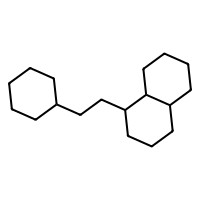
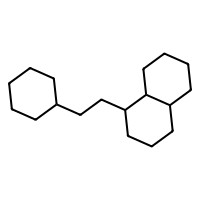
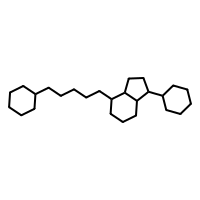
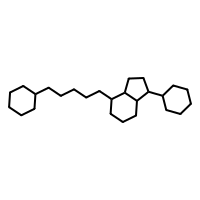
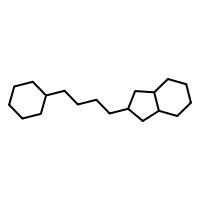
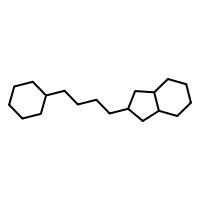
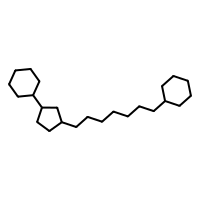
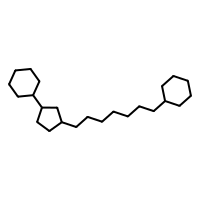
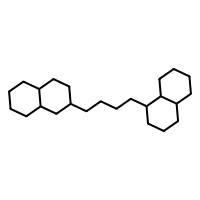
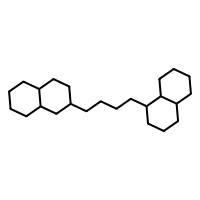
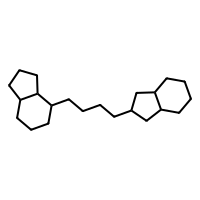
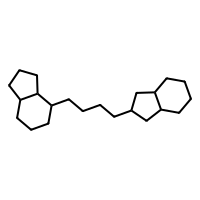
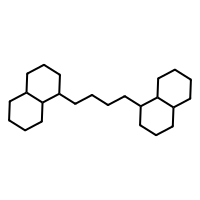
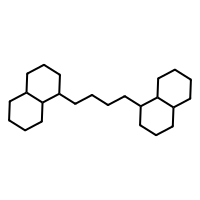
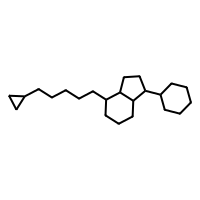
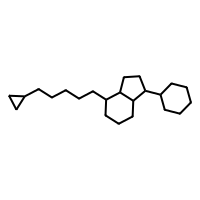
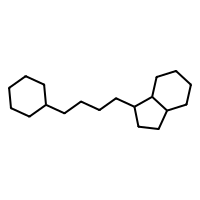
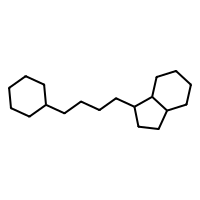
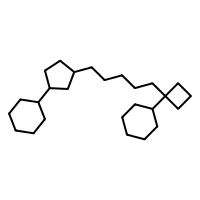
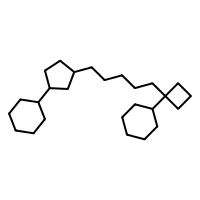
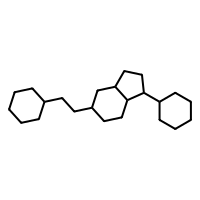
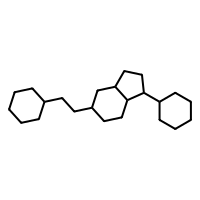
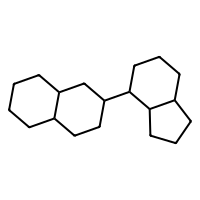
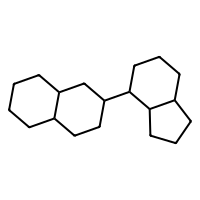
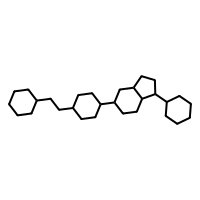
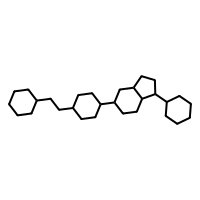
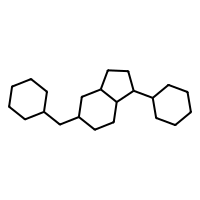
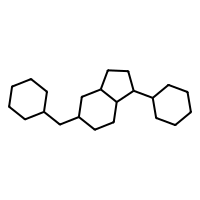
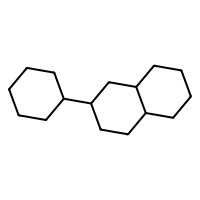
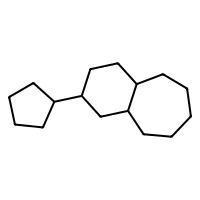
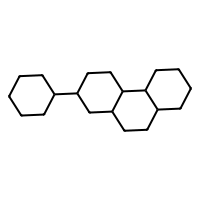
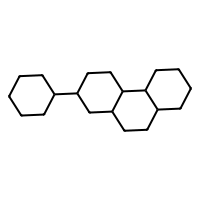
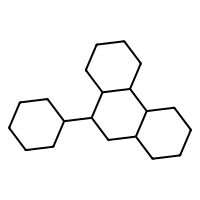
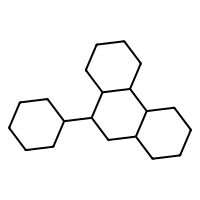
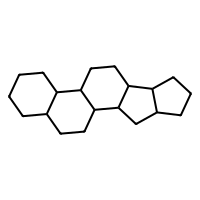
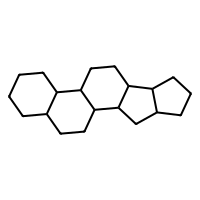
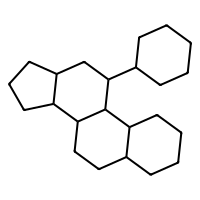
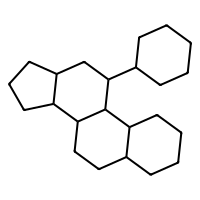
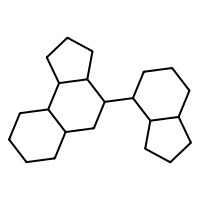
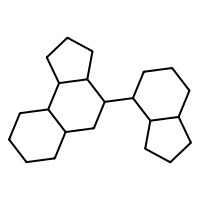
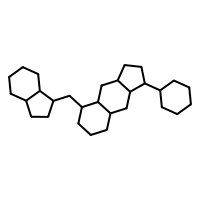
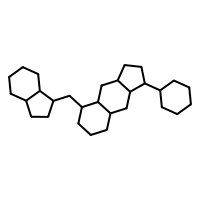
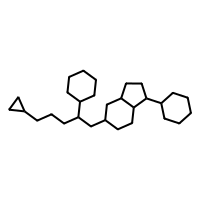
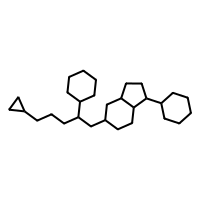
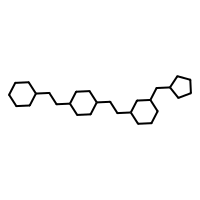
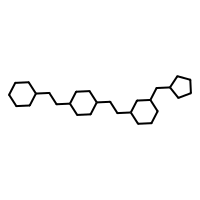
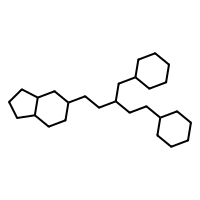
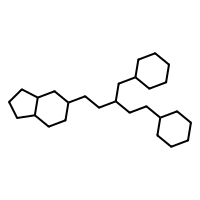
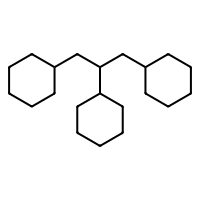
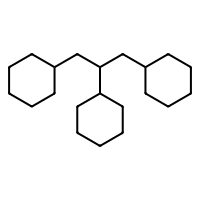
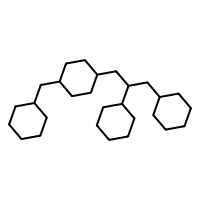
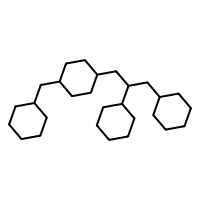
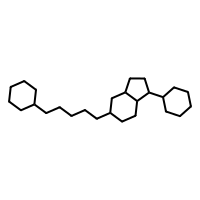
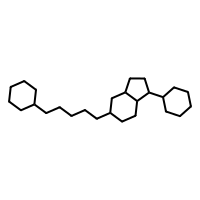
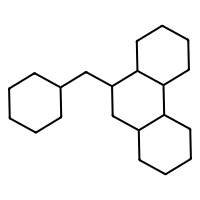
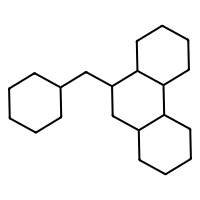
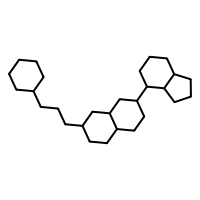
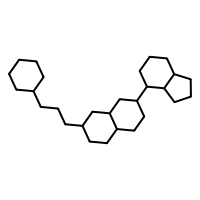
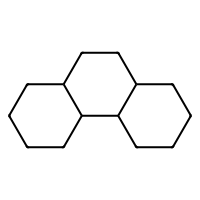
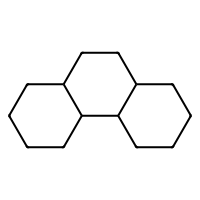
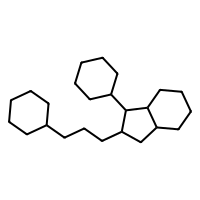
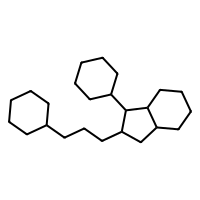
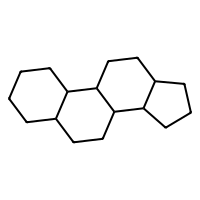
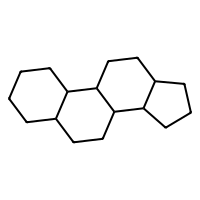

How much TC = 1:  554


----------------------------------------------------------------------------------------------------------------


DrugEx sim 0


[14:24:12] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:24:15] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:24:29] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:25:11] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


Delka recall setu:  616
X:  0
X:  1
X:  2
X:  3
X:  4
X:  5
X:  6
X:  7
X:  8
X:  9
X:  10
X:  11
X:  12
X:  13
X:  14
X:  15
X:  16
X:  17
X:  18
X:  19
X:  20
X:  21
X:  22
X:  23
X:  24
X:  25
X:  26
X:  27
X:  28
X:  29
X:  30
X:  31
X:  32
X:  33
X:  34
X:  35
X:  36
X:  37
X:  38
X:  39
X:  40
X:  41
X:  42
X:  43
X:  44
X:  45
X:  46
X:  47
X:  48
X:  49
X:  50
X:  51
X:  52
X:  53
X:  54
X:  55
X:  56
X:  57
X:  58
X:  59
X:  60
X:  61
X:  62
X:  63
X:  64
X:  65
X:  66
X:  67
X:  68
X:  69
X:  70
X:  71
X:  72
X:  73
X:  74
X:  75
X:  76
X:  77
X:  78
X:  79
X:  80
X:  81
X:  82
X:  83
X:  84
X:  85
X:  86
X:  87
X:  88
X:  89
X:  90
X:  91
X:  92
X:  93
X:  94
X:  95
X:  96
X:  97
X:  98
X:  99
X:  100
X:  101
X:  102
X:  103
X:  104
X:  105
X:  106
X:  107
X:  108
X:  109
X:  110
X:  111
X:  112
X:  113
X:  114
X:  115
X:  116
X:  117
X:  118
X:  119
X:  120
X:  121
X:  122
X:  123
X:  124
X:  125
X:  126
X:  127
X:  128
X:  129
X:  130
X:  131
X:  132
X:  133
X:  134
X:  13

In [ ]:
data = {}
for type in ['sim']:
    for num in range(5):
        molpher_set = pd.read_csv(f"data/results/Glucocorticoid_receptor/csk_scaffolds/{type}/Molpher/scaffolds_of_output_set_cluster_{num}_{type}_Molpher.csv", header=None)
        molpher_set.columns = ['virtual_compounds_smiles']
        molpher_set = molpher_set
        
        drugex_set = pd.read_csv(f"data/results/Glucocorticoid_receptor/csk_scaffolds/{type}/DrugEx/scaffolds_of_output_set_cluster_{num}_{type}_DrugEx.csv", header=None)
        drugex_set.columns = ['virtual_compounds_smiles']
        drugex_set = drugex_set

        recall_set = pd.read_csv(f"data/results/Glucocorticoid_receptor/csk_scaffolds/{type}/Molpher/scaffolds_of_recall_set_cluster_{num}_{type}_Molpher.csv", header=None)
        recall_set.columns = ['canonical_smiles']
        print("\n")
        print("----------------------------------------------------------------------------------------------------------------")
        print(f"Molpher {type} {num}")
        high_TC_recall_set_Molpher, array_Molpher= KL_divergence_prep(recall_set, molpher_set, 'canonical_smiles', 'virtual_compounds_smiles')
        dff = pd.DataFrame(data = high_TC_recall_set_Molpher)
        dff.to_csv(f"data/results/Glucocorticoid_receptor/csk_scaffolds/{type}/analysis_scaffolds/high_TC_recall_Molpher_{num}",header=None, index = False)
        array_Molpher.to_csv(f"data/results/Glucocorticoid_receptor/csk_scaffolds/{type}/analysis_scaffolds/array_with_tc_1_recall_Molpher_{num}",index = False)
        print("\n")
        print("----------------------------------------------------------------------------------------------------------------")
        print("\n")
        print(f"DrugEx {type} {num}")
        
        high_TC_recall_set_DrugEx, array_DrugEx = KL_divergence_prep(recall_set, drugex_set, 'canonical_smiles', 'virtual_compounds_smiles')
        dff_ = pd.DataFrame(data = high_TC_recall_set_DrugEx)
        dff_.to_csv(f"data/results/Glucocorticoid_receptor/csk_scaffolds/{type}/analysis_scaffolds/high_TC_recall_DrugEx_{num}",header=None, index = False)
        array_DrugEx.to_csv(f"data/results/Glucocorticoid_receptor/csk_scaffolds/{type}/analysis_scaffolds/array_with_tc_1_recall_DrugEx_{num}", index = False)


        data[f'generator_1_{type}_{num}'] = high_TC_recall_set_Molpher
        data[f'generator_2_{type}_{num}'] = high_TC_recall_set_DrugEx
#data 

In [ ]:
KL_histograms_for_all_10(5, data, 'Recall Set vs. Molpher and DrugEx in scaffolds')

In [ ]:
# Get the highest Tanimoto between morphing library and novel set
high_TC_novel_GRML_1 = KL_divergence_prep(novel_data, GRML_filtered, 'canonical_smiles', 'morph_smiles')
high_TC_novel_RML_1 = KL_divergence_prep(novel_data, RML_filtered, 'canonical_smiles', 'morph_smiles')

# Create histograms (probability distributions)
hist1, bin_edges = np.histogram(high_TC_novel_GRML_1, bins=100, range=(0, 1), density=True)
hist2, _ = np.histogram(high_TC_novel_RML_1, bins=100, range=(0, 1), density=True)

# Apply Laplace smoothing
smoothed_hist1 = (hist1 + 1e-10) / np.sum(hist1 + 1e-10)
smoothed_hist2 = (hist2 + 1e-10) / np.sum(hist2 + 1e-10)

# Compute KL divergence
kl_divergence = entropy(smoothed_hist1, smoothed_hist2)

print("KL Divergence:", kl_divergence)